In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as repr
import researchpy as rp
from scipy.stats import levene
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats

from sklearn.preprocessing import StandardScaler

import os

In [2]:
df = pd.read_pickle('datos/bikes_limpio.pkl') 

In [3]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual,cliente_registrado
indice,,,,,,,,,,,,
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.110847,10.749882,331,654
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,14.902598,16.652113,131,670
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.050924,16.636703,120,1229
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,8.200000,10.739832,108,1454
5,2018-05-01,primavera,2018,May,0,Martes,1,1,9.305237,12.522300,82,1518


# IDENTIFICAR OUTLIERS

In [4]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
    
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices

In [5]:
numericas = df.select_dtypes(include = np.number)

In [6]:
lista_col = list(numericas.columns)

In [7]:
diccionario_outliers = detectar_outliers(lista_col, df)

In [8]:
# iteramos por el diccionarios y cambiamos los outliers por nulos, para posteriormente poder tratarlos
 
for k, v in diccionario_outliers.items():
    for i in v:
        df.loc[i,k] = np.nan # usando el loc, reemmplazamos los valores de los outliers por los nulos 

In [9]:
imputer = IterativeImputer(n_nearest_features = None, 
                           imputation_order = 'ascending')

In [10]:
imputer.fit(numericas)

IterativeImputer()

In [11]:
imputer_trans = imputer.transform (numericas)

In [12]:
df_numericas_trans = pd.DataFrame(imputer_trans, columns = numericas.columns)

In [13]:
#Comprobamos que la transformación ha funcionado

df_numericas_trans.isnull().sum()

temperatura           0
velocidad_viento      0
cliente_casual        0
cliente_registrado    0
dtype: int64

In [14]:
#Eliminamos las columnas en el df original (ya tratadas en el df_numéricas) para posteriormente realizar la concatenación

df.drop(df_numericas_trans.columns, axis = 1, inplace=True)

In [15]:
#Concatenamos el df transformado

df = pd.concat([df, df_numericas_trans], axis = 1, join = 'inner')

In [16]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual,cliente_registrado
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,16.652113,131.0,670.0
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,16.636703,120.0,1229.0
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.739832,108.0,1454.0
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,12.522300,82.0,1518.0
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,6.000868,88.0,1518.0


In [17]:
#Comprobamos que la fusión de ambos df ya tratados y limpios no ha generado nulos

df.isnull().sum()

fecha                 0
estacion              0
año                   0
mes                   0
festivo               0
dia_semana            0
dia_laboral           0
tiempo                0
temperatura           0
velocidad_viento      0
cliente_casual        0
cliente_registrado    0
dtype: int64

## ASUNCIONES

### Evaluamos la normalidad de nuestras VR

- Las gráficas realizadas en el proceso de EDA nos han permitido ver que los datos de nuestras VR no parecían muy normales. No obstante, realizamos shapiro para confirmar.

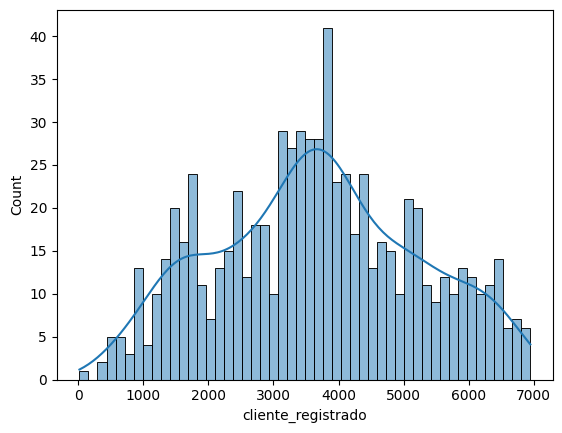

In [18]:
sns.histplot(x='cliente_registrado', data=df, kde=True, bins=50);

In [19]:
stats.shapiro(df['cliente_registrado'])

ShapiroResult(statistic=0.9844226837158203, pvalue=5.26244775755913e-07)

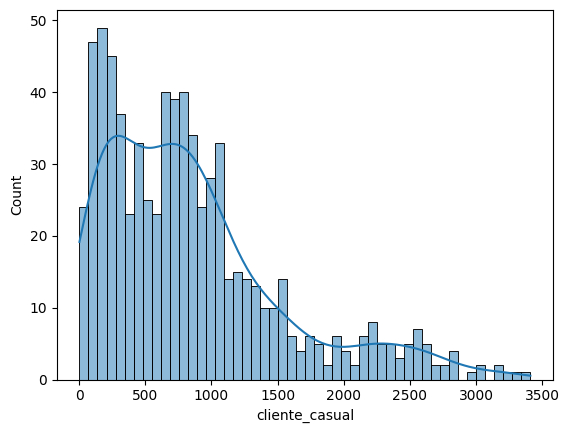

In [20]:
sns.histplot(x='cliente_casual', data=df, kde=True, bins=50);

In [21]:
stats.shapiro(df['cliente_casual'])

ShapiroResult(statistic=0.8853672742843628, pvalue=8.40218526941286e-23)

#### OBSERVACIONES:

- Nuestros datos no son normales:
  - los datos de los clientes_casuales están sesgados a la derecha y la distribución está muy lejos de ser normal.
  - los datos de los clientes_registrados parecen más "normales" pero observando el valor del p-value observamos que es menor que 0.05 y por tanto los datos no son normales tampoco.

 ### NORMALIZACIÓN DE VR

In [22]:
df.columns

Index(['fecha', 'estacion', 'año', 'mes', 'festivo', 'dia_semana',
       'dia_laboral', 'tiempo', 'temperatura', 'velocidad_viento',
       'cliente_casual', 'cliente_registrado'],
      dtype='object')

In [23]:
df['cliente_casual_box'], lambda_ajustada = stats.boxcox(df['cliente_casual'])

In [24]:
df['cliente_registrado_box'], lambda_ajustada = stats.boxcox(df['cliente_registrado'])

In [25]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual,cliente_registrado,cliente_casual_box,cliente_registrado_box
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,16.652113,131.0,670.0,11.502570,271.249335
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,16.636703,120.0,1229.0,11.104509,450.623255
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.739832,108.0,1454.0,10.640549,518.610737
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,12.522300,82.0,1518.0,9.497633,537.619305
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,6.000868,88.0,1518.0,9.781356,537.619305


/tmp/ipykernel_15468/348625325.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cliente_casual_box'] ,ax = axes[0])
/tmp/ipykernel_15468/348625325.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cliente_casual'], ax = axes[1]);


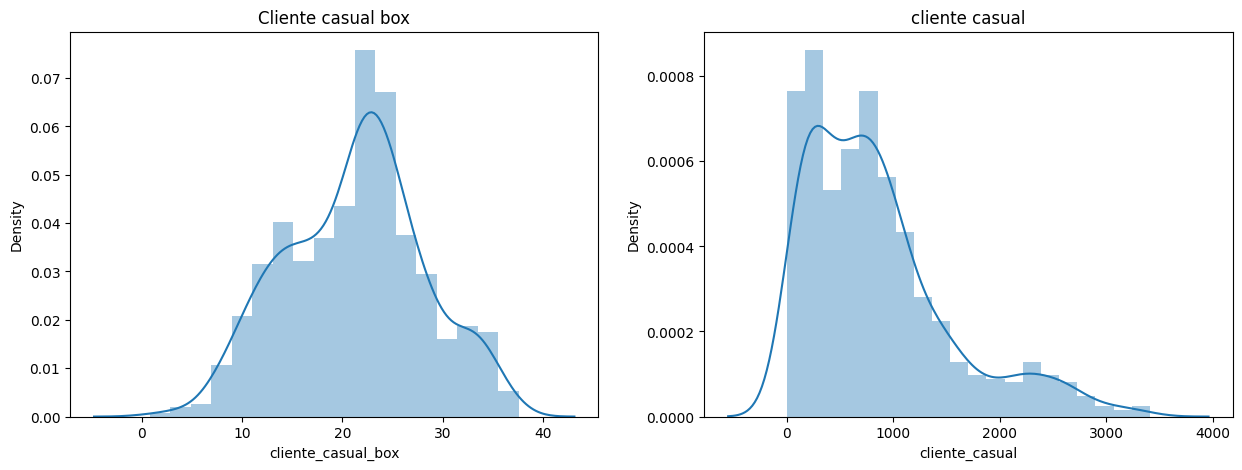

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('Cliente casual box')
axes[1].set_title('cliente casual')

sns.distplot(df['cliente_casual_box'] ,ax = axes[0])
sns.distplot(df['cliente_casual'], ax = axes[1]);

In [27]:
stats.shapiro(df["cliente_casual_box"])

ShapiroResult(statistic=0.9915052056312561, pvalue=0.00033736685873009264)

/tmp/ipykernel_15468/3985933847.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cliente_registrado_box'] ,ax = axes[0])
/tmp/ipykernel_15468/3985933847.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cliente_registrado'], ax = axes[1]);


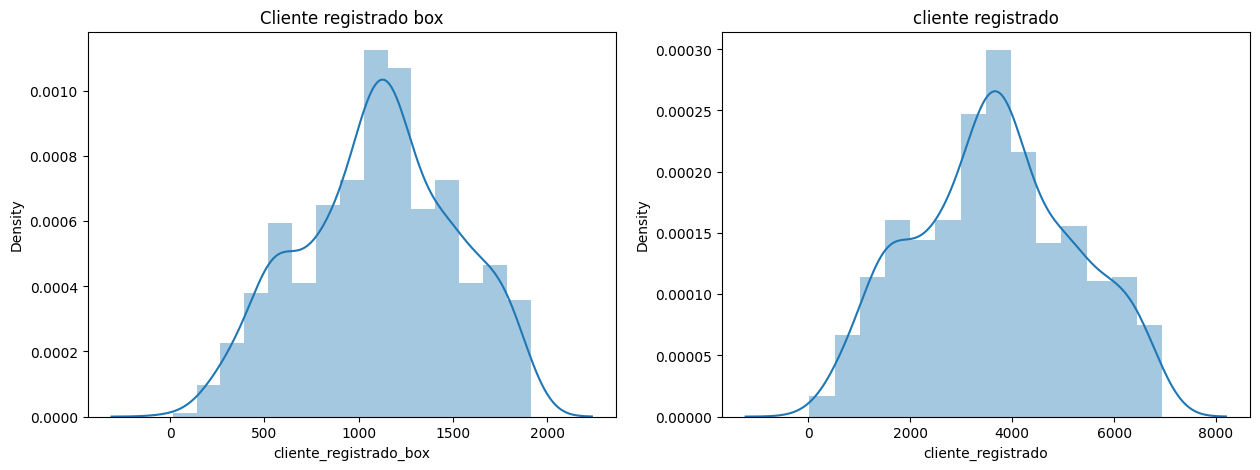

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('Cliente registrado box')
axes[1].set_title('cliente registrado')

sns.distplot(df['cliente_registrado_box'] ,ax = axes[0])
sns.distplot(df['cliente_registrado'], ax = axes[1]);

In [29]:
stats.shapiro(df["cliente_registrado_box"])

ShapiroResult(statistic=0.9855146408081055, pvalue=1.2759210221702233e-06)

#### OBSERVACIONES:

- Al aplicar el método boxcox, hemos comproado que nuestros datos no se pueden normalizar dado que nuestro p-value es menor a 0,5.
- Entonces, no podemos seguir con las asunciones para el ANOVA ni la regresión lineal, ya que vamos a tener que usar un modelo de Decision Tree o Random Forest

In [30]:
df.drop(['cliente_registrado_box', 'cliente_casual_box'], axis=1, inplace=True)

In [31]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual,cliente_registrado
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,16.652113,131.0,670.0
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,16.636703,120.0,1229.0
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.739832,108.0,1454.0
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,12.522300,82.0,1518.0
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,6.000868,88.0,1518.0


### COMPROBAMOS LA INDEPENDENCIA

In [32]:
categoricas = df.select_dtypes(exclude=np.number)
col_cat = categoricas.columns.to_list()

In [33]:
col_cat

['fecha',
 'estacion',
 'año',
 'mes',
 'festivo',
 'dia_semana',
 'dia_laboral',
 'tiempo']

In [34]:
lista_V_Cramer_alto = []
lista_V_Cramer_bajo = []
# mas o menos que 0,7

for i, col in enumerate(categoricas.columns):
    
    for x in col_cat:
        if col == x:
            pass
        else:
            crosstab, test_results, expected = rp.crosstab(df[col], df[x],
                                    test= "chi-square",
                                    expected_freqs= True,
                                    prop= "cell")
            
            if test_results.iloc[2,1] > 0.7:
                lista_V_Cramer_alto.append(f'V-Cramer de {col} y {x}: {test_results.iloc[2,1]}')
            else:
                lista_V_Cramer_bajo.append(f'V-Cramer de {col} y {x}: {test_results.iloc[2,1]}')
            
    col_cat.remove(col)
    
print('V-Cramer bajo:')
for i in lista_V_Cramer_bajo:
    print(i)
    
print('V-Cramer alto:')
for i in lista_V_Cramer_alto:
    print(i)

V-Cramer bajo:
V-Cramer de estacion y año: 0.0024
V-Cramer de estacion y festivo: 0.0678
V-Cramer de estacion y dia_semana: 0.0122
V-Cramer de estacion y dia_laboral: 0.0296
V-Cramer de estacion y tiempo: 0.0786
V-Cramer de año y mes: 0.0045
V-Cramer de año y festivo: 0.0084
V-Cramer de año y dia_semana: 0.0033
V-Cramer de año y dia_laboral: 0.002
V-Cramer de año y tiempo: 0.0755
V-Cramer de mes y festivo: 0.142
V-Cramer de mes y dia_semana: 0.0359
V-Cramer de mes y dia_laboral: 0.0536
V-Cramer de mes y tiempo: 0.1498
V-Cramer de festivo y dia_semana: 0.237
V-Cramer de festivo y dia_laboral: 0.2433
V-Cramer de festivo y tiempo: 0.0324
V-Cramer de dia_semana y tiempo: 0.0855
V-Cramer de dia_laboral y tiempo: 0.0672
V-Cramer alto:
V-Cramer de fecha y estacion: 1.0
V-Cramer de fecha y año: 1.0
V-Cramer de fecha y mes: 1.0
V-Cramer de fecha y festivo: 1.0
V-Cramer de fecha y dia_semana: 1.0
V-Cramer de fecha y dia_laboral: 1.0
V-Cramer de fecha y tiempo: 1.0
V-Cramer de estacion y mes: 0.8

Por los V-Cramer de las variables categóricas, podemos ver que tenemos unas columnas redundantes.

- la columna 'fecha' tiene un V-Cramer alto contra varias variables, así que vamos a prescindir de ella

- entre 'estación' y 'mes', nos vamos a quedar con la columna de 'mes' porque aporta información más detallada para el cliente

- entre 'dia_semana' y 'dia_laboral', nos vamos a quedar con la columna de 'dia_semana' porque la misma razón

In [35]:
df.columns

Index(['fecha', 'estacion', 'año', 'mes', 'festivo', 'dia_semana',
       'dia_laboral', 'tiempo', 'temperatura', 'velocidad_viento',
       'cliente_casual', 'cliente_registrado'],
      dtype='object')

In [36]:
df.drop('fecha', axis=1, inplace=True)

In [37]:
df.head()

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual,cliente_registrado
1,invierno,2018,January,1,Lunes,0,2,14.902598,16.652113,131.0,670.0
2,invierno,2018,February,0,Jueves,1,2,8.050924,16.636703,120.0,1229.0
3,invierno,2018,March,0,Jueves,1,1,8.200000,10.739832,108.0,1454.0
4,primavera,2018,April,0,Domingo,0,1,9.305237,12.522300,82.0,1518.0
5,primavera,2018,May,0,Martes,1,1,8.378268,6.000868,88.0,1518.0


In [38]:
df.to_csv('datos/bikes_limpio_final.csv')
df.to_pickle('datos/bikes_limpio_final.pkl')

### COMPROBAMOS LA HOMOCEDASTICIDAD

In [39]:
categoricas = df.select_dtypes(exclude=np.number)
categoricas.columns

Index(['estacion', 'año', 'mes', 'festivo', 'dia_semana', 'dia_laboral',
       'tiempo'],
      dtype='object')

In [40]:
numericas = df.select_dtypes(include=np.number)
numericas.columns

Index(['temperatura', 'velocidad_viento', 'cliente_casual',
       'cliente_registrado'],
      dtype='object')

In [41]:
for i in categoricas.columns:
    print(df[i].unique())

['invierno' 'primavera' 'verano' 'otoño']
['2018' '2019']
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
[1, 0]
Categories (2, int64): [0, 1]
['Lunes' 'Jueves' 'Domingo' 'Martes' 'Viernes' 'Miercoles' 'Sabado']
[0, 1]
Categories (2, int64): [0, 1]
[2, 1, 3]
Categories (3, int64): [1, 2, 3]


In [42]:
df_2018_casual = df[df['año'] == '2018']['cliente_casual']
df_2019_casual = df[df['año'] == '2019']['cliente_casual']

In [43]:
levene_test = stats.levene(df_2018_casual, df_2019_casual, center='median')
levene_test

LeveneResult(statistic=20.299150506834316, pvalue=7.715151914893317e-06)

## ENCODING

In [44]:
df_categoricas = df.select_dtypes(exclude = np.number)
df_categoricas.head(2)

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo
1,invierno,2018,January,1,Lunes,0,2
2,invierno,2018,February,0,Jueves,1,2


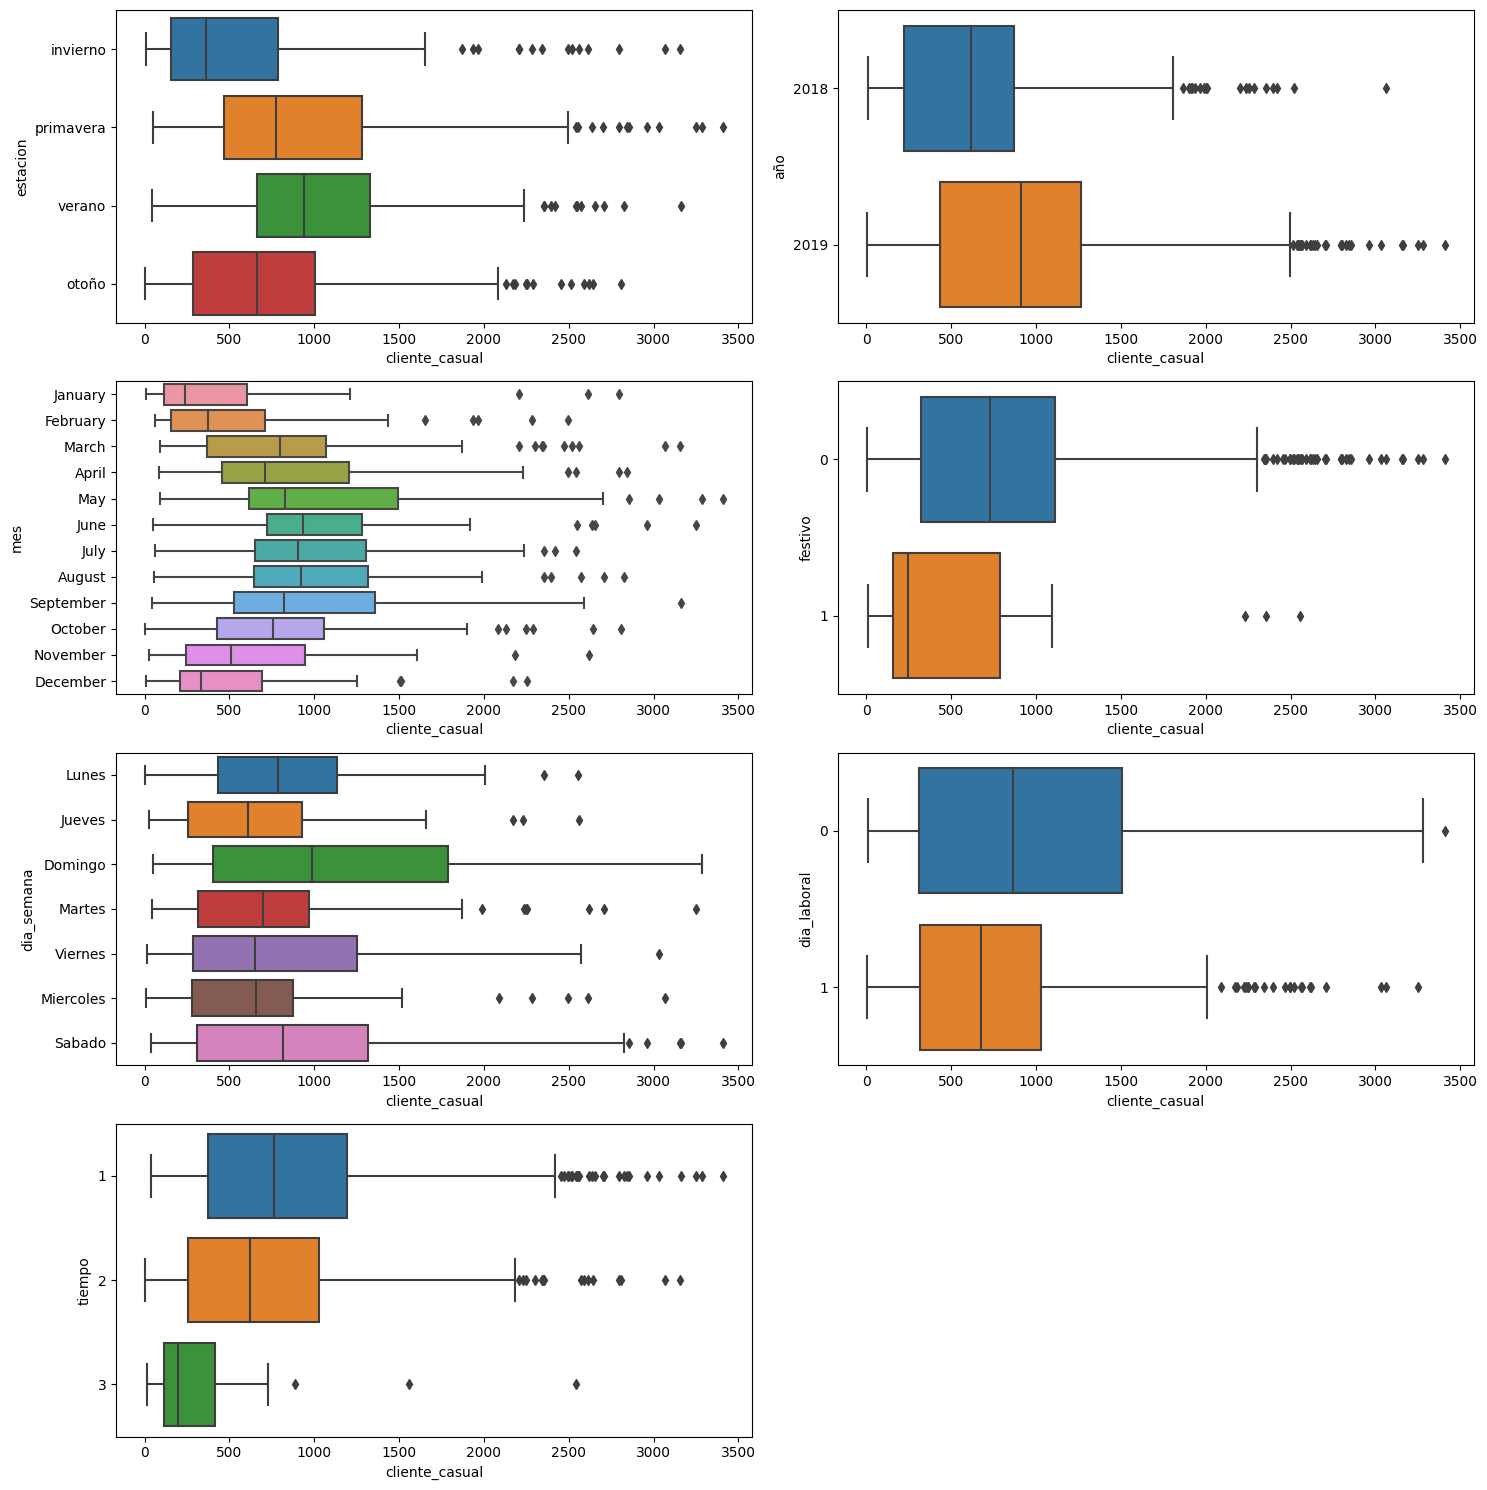

In [45]:
# creamos boxplots de la variable respuesta de clientes casuales para determinar si las
# variables categoricas tienen orden 

fig, axes = plt.subplots(4, 2, figsize=(15,15))

axes = axes.flat

for i, col in enumerate(df_categoricas.columns):
    sns.boxplot(y=col, x='cliente_casual', data=df, ax=axes[i])

fig.delaxes(axes[-1])

plt.tight_layout();

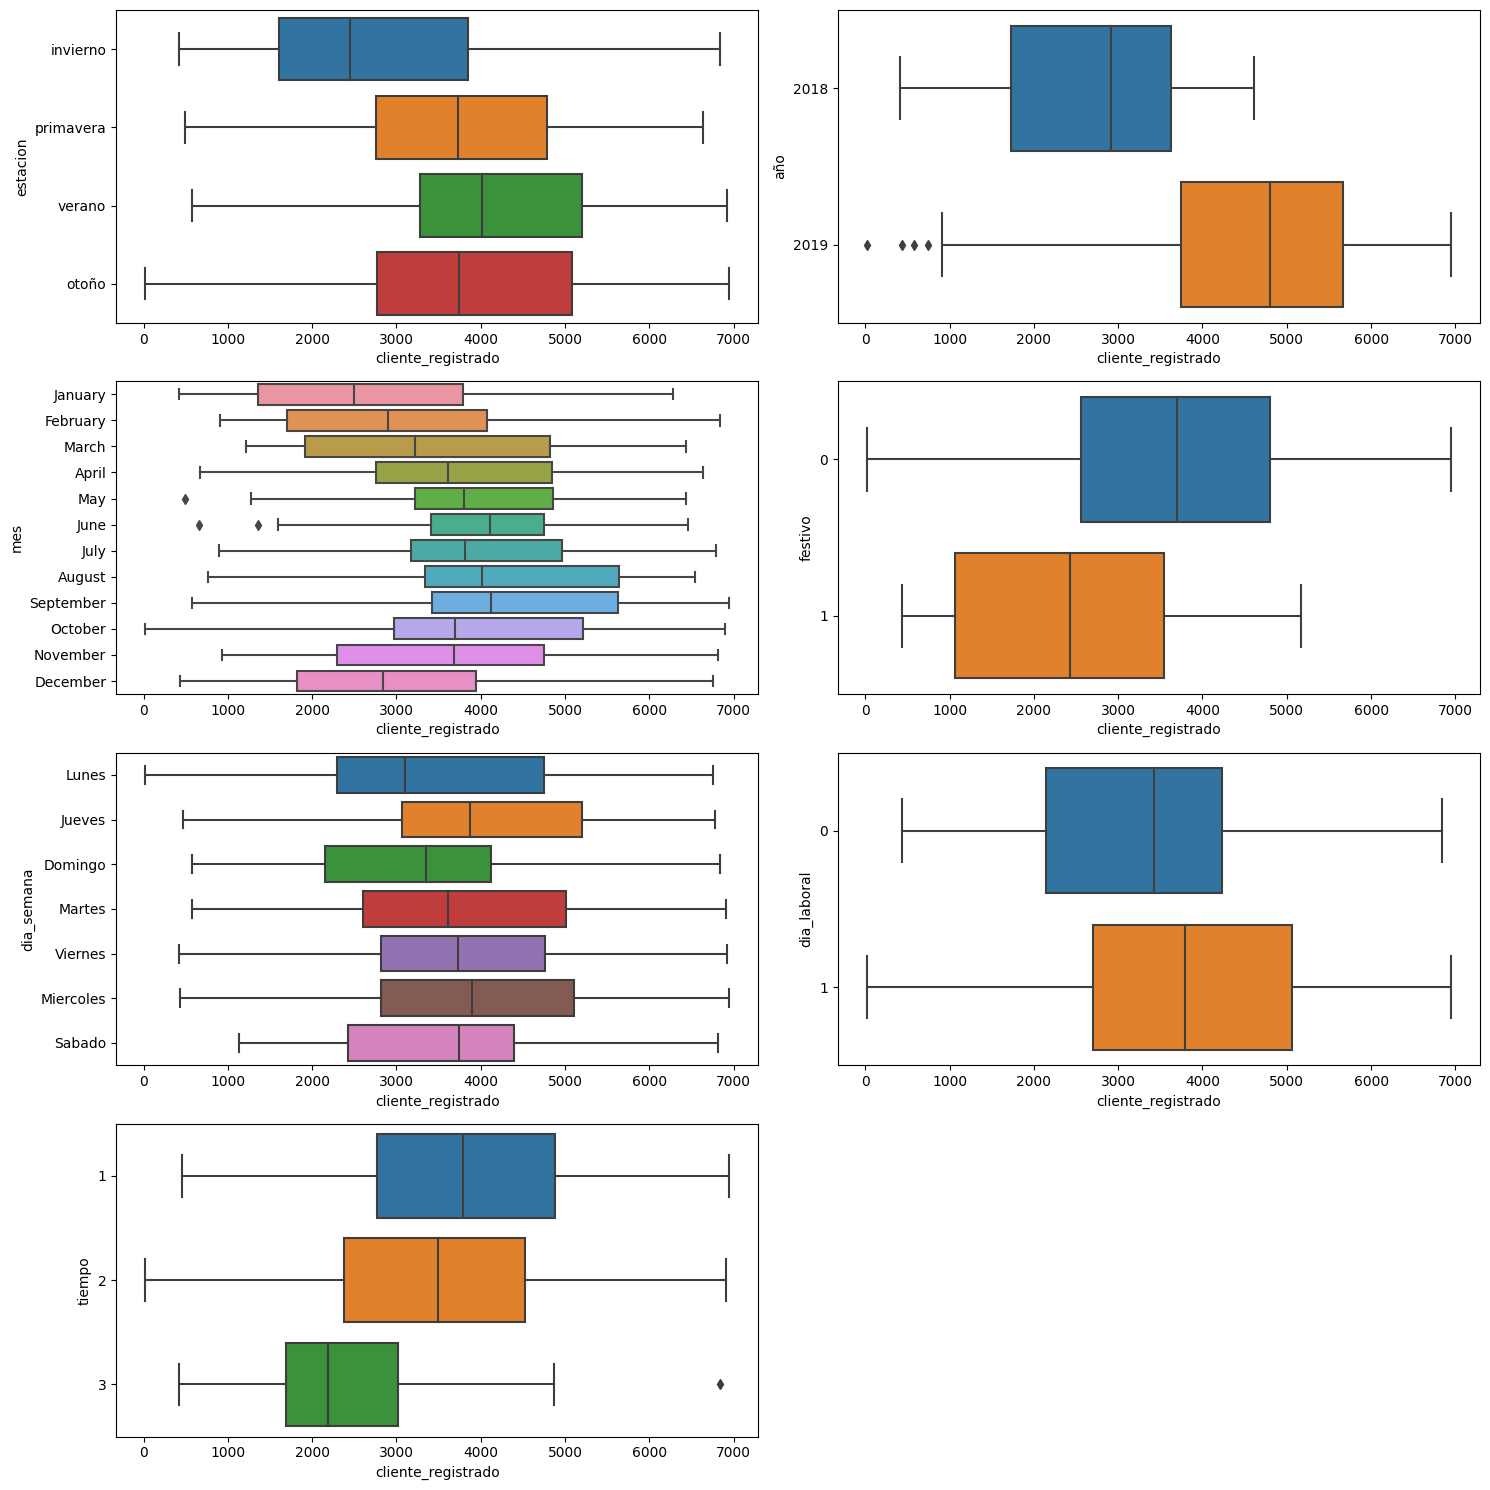

In [46]:
# creamos boxplots de la variable respuesta de clientes registrados para determinar si las
# variables categoricas tienen orden 

fig, axes = plt.subplots(4, 2, figsize=(15,15))

axes = axes.flat

for i, col in enumerate(df_categoricas.columns):
    sns.boxplot(y=col, x='cliente_registrado', data=df, ax=axes[i])

fig.delaxes(axes[-1])

plt.tight_layout();

## Encoding para la VR de clientes casuales

- podemos ver que todas las medianas de las variables categóricas difieren, lo que significa que sí que afectan a la VR y tienen ordén


In [47]:
dicc_encoding = {}

for col in df_categoricas.columns:
    
    df_group = df.groupby(col)['cliente_casual'].median()
    df_group = pd.DataFrame(df_group)
    df_group = df_group.sort_values(by='cliente_casual')
    df_group['encoding'] = round(df_group['cliente_casual']/df_group.iloc[0,0], 2)
    display(df_group)
    

,cliente_casual,encoding
estacion,,
invierno,359.0,1.00
otoño,665.0,1.85
primavera,776.0,2.16
verano,937.0,2.61


,cliente_casual,encoding
año,,
2018,616.0,1.00
2019,913.0,1.48


,cliente_casual,encoding
mes,,
January,237.5,1.00
December,333.0,1.40
February,371.5,1.56
November,508.0,2.14
April,711.5,3.00
October,756.5,3.19
March,795.5,3.35
September,824.5,3.47
May,827.5,3.48


,cliente_casual,encoding
festivo,,
1,244.0,1.00
0,727.5,2.98


,cliente_casual,encoding
dia_semana,,
Jueves,612.0,1.00
Viernes,648.5,1.06
Miercoles,657.0,1.07
Martes,699.0,1.14
Lunes,784.0,1.28
Sabado,813.5,1.33
Domingo,984.0,1.61


,cliente_casual,encoding
dia_laboral,,
1,677.0,1.00
0,867.0,1.28


,cliente_casual,encoding
tiempo,,
3,195.0,1.00
2,620.0,3.18
1,763.0,3.91


In [48]:
map_estacion = {'invierno':1 , 'otoño': 2, 'primavera':2 , 'verano':2.5 }

In [49]:
map_año = {'2018': 1,
           '2019': 1.5}

In [50]:
map_mes = {'January': 1,
           'December': 1.5,
           'February': 1.5,
           'November': 2,
           'April': 3,
           'October': 3,
           'March': 3.5,
           'September': 3.5,
           'May': 3.5,
           'July': 4,
           'August': 4,
           'June': 4}

In [51]:
map_festivo = {1: 1,
               0: 3}

In [52]:
map_dias = {'Jueves': 1,
            'Viernes': 1,
            'Miercoles': 1,
            'Martes': 1,
            'Lunes': 1.5,
            'Sabado': 1.5,
            'Domingo': 1.5}

In [53]:
map_tiempo = {3: 1,
               2: 3,
               1: 4}

In [54]:
map_laboral = {1: 1, 
               0:1.5}

In [55]:
df_casual = df.copy().drop('cliente_registrado', axis=1)
df_casual.head(2)

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual
1,invierno,2018,January,1,Lunes,0,2,14.902598,16.652113,131.0
2,invierno,2018,February,0,Jueves,1,2,8.050924,16.636703,120.0


In [56]:
df_casual['estacion'] = df_casual['estacion'].map(map_estacion)

In [57]:
df_casual['año'] = df_casual['año'].map(map_año)

In [58]:
df_casual['mes'] = df_casual['mes'].map(map_mes)

In [59]:
df_casual['festivo'] = df_casual['festivo'].map(map_festivo)

In [60]:
df_casual['dia_semana'] = df_casual['dia_semana'].map(map_dias)

In [61]:
df_casual['tiempo'] = df_casual['tiempo'].map(map_tiempo)

In [62]:
df_casual['dia_laboral'] = df_casual['dia_laboral'].map(map_laboral)

In [63]:
df_casual.head()

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_casual
1,1.0,1.0,1.0,1,1.5,1.5,3,14.902598,16.652113,131.0
2,1.0,1.0,1.5,3,1.0,1.0,3,8.050924,16.636703,120.0
3,1.0,1.0,3.5,3,1.0,1.0,4,8.200000,10.739832,108.0
4,2.0,1.0,3.0,3,1.5,1.5,4,9.305237,12.522300,82.0
5,2.0,1.0,3.5,3,1.0,1.0,4,8.378268,6.000868,88.0


In [64]:
df_casual.isnull().sum()

estacion            0
año                 0
mes                 0
festivo             0
dia_semana          0
dia_laboral         0
tiempo              0
temperatura         0
velocidad_viento    0
cliente_casual      0
dtype: int64

### Encoding para VR clientes registrados

In [65]:
for col in df_categoricas.columns:
    
    df_group2 = df.groupby(col)['cliente_registrado'].median()
    df_group2 = pd.DataFrame(df_group2)
    df_group2 = df_group2.sort_values(by='cliente_registrado')
    df_group2['encoding'] = round(df_group2['cliente_registrado']/df_group2.iloc[0,0], 2)
    display(df_group2)

,cliente_registrado,encoding
estacion,,
invierno,2451.0,1.00
primavera,3725.5,1.52
otoño,3746.5,1.53
verano,4020.0,1.64


,cliente_registrado,encoding
año,,
2018,2915.0,1.00
2019,4795.5,1.65


,cliente_registrado,encoding
mes,,
January,2493.5,1.00
December,2841.0,1.14
February,2895.5,1.16
March,3221.0,1.29
April,3606.0,1.45
November,3680.0,1.48
October,3691.0,1.48
May,3799.5,1.52
July,3809.0,1.53


,cliente_registrado,encoding
festivo,,
1,2433.0,1.00
0,3694.5,1.52


,cliente_registrado,encoding
dia_semana,,
Lunes,3105.0,1.00
Domingo,3353.0,1.08
Martes,3609.5,1.16
Viernes,3730.0,1.20
Sabado,3737.0,1.20
Jueves,3877.5,1.25
Miercoles,3898.0,1.26


,cliente_registrado,encoding
dia_laboral,,
0,3420.0,1.00
1,3788.0,1.11


,cliente_registrado,encoding
tiempo,,
3,2186.0,1.00
2,3489.0,1.60
1,3788.0,1.73


In [66]:
map_estacion2 = {'invierno': 1, 'primavera': 1.5, 'otoño': 1.5, 'verano': 1.5}

In [67]:
map_año2 = {'2018': 1,
            '2019': 1.5}

map_mes2 = {'January': 1,
           'December': 1,
           'February': 1,
           'March': 1.5,
           'April': 1.5,
           'November': 1.5,
           'October': 1.5,
           'May': 1.5,
           'July': 1.5,
           'August': 1.5,
           'June': 1.5,
           'September': 1.5}

map_festivo2 = {1: 1,
                0: 1.5}

map_tiempo2 = {3: 1,
              2: 1.5,
              1: 1.5}

In [68]:
df_registrado = df.copy().drop('cliente_casual', axis=1)
df_registrado.head(2)

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_registrado
1,invierno,2018,January,1,Lunes,0,2,14.902598,16.652113,670.0
2,invierno,2018,February,0,Jueves,1,2,8.050924,16.636703,1229.0


In [69]:
df_registrado['estacion'] = df_registrado['estacion'].map(map_estacion2)

In [70]:
df_registrado['año'] = df_registrado['año'].map(map_año2)

In [71]:
df_registrado['mes'] = df_registrado['mes'].map(map_mes2)

In [72]:
df_registrado['festivo'] = df_registrado['festivo'].map(map_festivo2)

In [73]:
df_registrado['tiempo'] = df_registrado['tiempo'].map(map_tiempo2)

In [74]:
df_registrado.head()

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,velocidad_viento,cliente_registrado
1,1.0,1.0,1.0,1.0,Lunes,0,1.5,14.902598,16.652113,670.0
2,1.0,1.0,1.0,1.5,Jueves,1,1.5,8.050924,16.636703,1229.0
3,1.0,1.0,1.5,1.5,Jueves,1,1.5,8.200000,10.739832,1454.0
4,1.5,1.0,1.5,1.5,Domingo,0,1.5,9.305237,12.522300,1518.0
5,1.5,1.0,1.5,1.5,Martes,1,1.5,8.378268,6.000868,1518.0


In [75]:
df_dummies = pd.get_dummies(df_registrado, columns = ['dia_semana', 'dia_laboral'], dtype=int)

In [76]:
df_registrado[df_dummies.columns] = df_dummies

In [77]:
df_registrado.drop(['dia_semana', 'dia_laboral'], axis=1, inplace=True)

In [78]:
df_registrado.head(2)

,estacion,año,mes,festivo,tiempo,temperatura,velocidad_viento,cliente_registrado,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miercoles,dia_semana_Sabado,dia_semana_Viernes,dia_laboral_0,dia_laboral_1
1,1.0,1.0,1.0,1.0,1.5,14.902598,16.652113,670.0,0,0,1,0,0,0,0,1,0
2,1.0,1.0,1.0,1.5,1.5,8.050924,16.636703,1229.0,0,1,0,0,0,0,0,0,1


In [79]:
columnas = {'dia_laboral_0': 'no_dia_laboral', 'dia_laboral_1': 'si_dia_laboral'}
df_registrado.rename(columns = columnas, inplace=True)

In [80]:
df_registrado.head()

,estacion,año,mes,festivo,tiempo,temperatura,velocidad_viento,cliente_registrado,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miercoles,dia_semana_Sabado,dia_semana_Viernes,no_dia_laboral,si_dia_laboral
1,1.0,1.0,1.0,1.0,1.5,14.902598,16.652113,670.0,0,0,1,0,0,0,0,1,0
2,1.0,1.0,1.0,1.5,1.5,8.050924,16.636703,1229.0,0,1,0,0,0,0,0,0,1
3,1.0,1.0,1.5,1.5,1.5,8.200000,10.739832,1454.0,0,1,0,0,0,0,0,0,1
4,1.5,1.0,1.5,1.5,1.5,9.305237,12.522300,1518.0,1,0,0,0,0,0,0,1,0
5,1.5,1.0,1.5,1.5,1.5,8.378268,6.000868,1518.0,0,0,0,1,0,0,0,0,1


## ESTANDARIZACIÓN

- como hemos gestiando los outliers, vamos a usar el método StandardScaler de Sklearn para estandarizar las variables predictoras numéricas

In [81]:
# creamos de nuevo un dataframe de las variables numericas que vamos a estandarizar

df_numericas = df.select_dtypes(include=np.number)
df_numericas.head(2)

,temperatura,velocidad_viento,cliente_casual,cliente_registrado
1,14.902598,16.652113,131.0,670.0
2,8.050924,16.636703,120.0,1229.0


In [82]:
# creamos la instancia del model

scaler = StandardScaler()

In [83]:
# ajustamos el modelo

scaler.fit(df_numericas)

StandardScaler()

In [84]:
# aplicamos el modelo a los datos numericas

X_escaladas = scaler.transform(df_numericas)

In [85]:
# creamos un dataframe de los datos estandarizados

df_estandarizada = pd.DataFrame(X_escaladas, columns = df_numericas.columns)

In [86]:
df_estandarizada.drop(['cliente_casual', 'cliente_registrado'], axis=1, inplace=True)

In [87]:
# eliminamos las columnas originales para poder añadir las columnas estandarizadas

df_casual.drop(df_estandarizada.columns, axis=1, inplace=True)

In [88]:
# eliminamos las columnas originales para poder añadir las columnas estandarizadas

df_registrado.drop(df_estandarizada.columns, axis=1, inplace=True)

In [89]:
df_estandarizada.head(2)

,temperatura,velocidad_viento
0,-0.723048,0.747931
1,-1.636215,0.744965


In [90]:
# añadimos las columnas estandarizadas

df_casual[df_estandarizada.columns] = df_estandarizada

In [91]:
df_casual.head()

,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,cliente_casual,temperatura,velocidad_viento
1,1.0,1.0,1.0,1,1.5,1.5,3,131.0,-1.636215,0.744965
2,1.0,1.0,1.5,3,1.0,1.0,3,120.0,-1.616347,-0.390073
3,1.0,1.0,3.5,3,1.0,1.0,4,108.0,-1.469045,-0.046981
4,2.0,1.0,3.0,3,1.5,1.5,4,82.0,-1.592588,-1.302236
5,2.0,1.0,3.5,3,1.0,1.0,4,88.0,-1.635352,-0.281358


In [92]:
# añadimos las columnas estandarizadas

df_registrado[df_estandarizada.columns] = df_estandarizada

In [93]:
df_registrado.head(2)

,estacion,año,mes,festivo,tiempo,cliente_registrado,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miercoles,dia_semana_Sabado,dia_semana_Viernes,no_dia_laboral,si_dia_laboral,temperatura,velocidad_viento
1,1.0,1.0,1.0,1.0,1.5,670.0,0,0,1,0,0,0,0,1,0,-1.636215,0.744965
2,1.0,1.0,1.0,1.5,1.5,1229.0,0,1,0,0,0,0,0,0,1,-1.616347,-0.390073


In [94]:
df_casual.to_pickle('datos/bikes_casual_estand.pkl')

In [95]:
df_casual.to_csv('datos/bikes_casual_estand.csv')

In [96]:
df_registrado.to_pickle('datos/bikes_registrado_estand.pkl')

In [97]:
df_registrado.to_csv('datos/bikes_registrado_estand.csv')